# improve_data_label_v12_b

v8~v10 비교를 바탕으로 **좌표 붕괴(collapse)**를 줄이고, K=5 후보의 **다양성**과 **스케일/국소 기하**를 더 안정적으로 학습하도록 수정한 v12_b이다.

핵심 변경점:
- CoordHead를 `DeltaCoordHead`로 교체: per-residue **delta**를 예측하고 **cumsum**으로 좌표를 구성(연속성/스프레드 유도)
- softmin 온도 상향 + **head diversity loss** 추가(한 헤드로 쏠림/죽는 헤드 방지)
- non-neighbor에 대한 **repulsion hinge** 추가(겹침 방지)
- confidence head는 유지(후보 랭킹 보조)


v12_b: **Distance-matrix auxiliary head**(multi-task) 추가로 long-range topology 학습을 강화한다.


In [1]:

# ==========================================
# 0) Imports, Device, Config  [v11]
# ==========================================
import os, math, random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from tqdm import tqdm
from dataclasses import dataclass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)


device: cuda


In [2]:

@dataclass
class CFG:
    seed: int = 42
    max_len: int = 256
    min_valid: int = 30

    # model
    n_tokens: int = 5           # PAD=0, A=1,C=2,G=3,U=4
    d_model: int = 256
    nhead: int = 8
    layers: int = 6
    dropout: float = 0.1
    num_preds: int = 5

    # train
    batch: int = 16
    epochs: int = 80
    warmup_epochs: int = 5
    lr: float = 5e-5            # v8보다 너무 낮으면 collapse에서 못 빠져나오는 경우가 있어 약간 상향
    wd: float = 1e-2
    grad_clip: float = 1.0
    num_workers: int = 0

    # loss
    dist_w: float = 0.08
    softmin_temp: float = 0.80          # v9/v10(0.3)에서 head 쏠림이 심해져서 상향
    pair_num_pairs: int = 2048


    # distance-matrix auxiliary (multi-task)
    distmat_w: float = 0.20
    distmat_num_pairs: int = 4096
    # regularizers
    var_w: float = 0.01
    local_w: float = 0.10
    repulse_w: float = 0.05             # non-neighbor 겹침 방지
    repulse_margin: float = 2.5         # Å 단위 가정(데이터에 맞춰 조절)
    diversity_w: float = 0.05           # head 다양성
    diversity_margin: float = 2.0

    # candidate confidence (ranking)
    use_confidence: bool = True
    conf_w: float = 0.05

    # amp
    use_amp: bool = True

    # early stop
    patience: int = 10
    ckpt_path: str = "best_structured_v12b.pt"
    ckpt_stage1_path: str = "best_stage1_v12b.pt"
    dist_w_ramp_epochs: int = 8

cfg = CFG()

def seed_all(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_all(cfg.seed)


## 1) Dataset / Data Loading

v10과 동일한 데이터 로딩/라벨 구성 로직을 그대로 사용한다. 아래 셀은 v10 노트북에서 그대로 가져온 부분이다.

In [3]:

# ==========================================
# 1) Load CSVs
# ==========================================
train_seq = pd.read_csv("train_sequences.csv")
val_seq   = pd.read_csv("validation_sequences.csv")

train_labels = pd.read_csv("train_labels.csv")
val_labels   = pd.read_csv("validation_labels.csv")

print("train_seq:", train_seq.shape, "val_seq:", val_seq.shape)
print("train_labels:", train_labels.shape, "val_labels:", val_labels.shape)

# ==========================================
# 2) Tokenize sequences (A,C,G,U -> 1..4, PAD=0)
# ==========================================
mapping = {'A': 1, 'C': 2, 'G': 3, 'U': 4}

def tokenize_sequence(seq: str):
    # unknown -> 0 (PAD)
    return [mapping.get(ch, 0) for ch in seq]

train_seq['tokens'] = train_seq['sequence'].astype(str).apply(tokenize_sequence)
val_seq['tokens']   = val_seq['sequence'].astype(str).apply(tokenize_sequence)

print(train_seq[['target_id','sequence']].head())
# ==========================================
# 3) Build coordinates + coord_mask from labels
# ==========================================
XYZ = ['x_1','y_1','z_1']
THRESH = 1e17

def _make_target_id_and_resid(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['target_id'] = df['ID'].astype(str).str.rsplit('_', n=1).str[0]
    df['resid'] = pd.to_numeric(df['resid'], errors='coerce')
    df = df.dropna(subset=['resid']).copy()
    df['resid'] = df['resid'].astype(int)
    df = df.sort_values(['target_id','resid'])
    return df

def build_coords_from_train_labels(train_labels: pd.DataFrame) -> pd.DataFrame:
    df = _make_target_id_and_resid(train_labels)
    for c in XYZ:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    arr = df[XYZ].to_numpy(dtype=np.float64)
    ok = np.isfinite(arr).all(axis=1) & (np.abs(arr) < THRESH).all(axis=1)
    df['coord_ok'] = ok.astype(np.float32)
    df.loc[~ok, XYZ] = 0.0
    df[XYZ] = df[XYZ].astype(np.float32)

    coords_df = (df.groupby('target_id')[XYZ]
                 .apply(lambda x: x.to_numpy(np.float32).tolist())
                 .reset_index(name='coordinates'))
    mask_df   = (df.groupby('target_id')['coord_ok']
                 .apply(lambda x: x.to_numpy(np.float32).tolist())
                 .reset_index(name='coord_mask'))
    return coords_df.merge(mask_df, on='target_id', how='inner')

def build_coords_from_val_labels(val_labels: pd.DataFrame, K: int = 40) -> pd.DataFrame:
    df = _make_target_id_and_resid(val_labels)

    chosen = np.zeros((len(df), 3), dtype=np.float32)
    ok_mask = np.zeros((len(df),), dtype=np.float32)
    filled = np.zeros((len(df),), dtype=bool)

    for k in range(1, K+1):
        cols = [f'x_{k}', f'y_{k}', f'z_{k}']
        if not all(c in df.columns for c in cols):
            continue
        tmp = df[cols].apply(pd.to_numeric, errors='coerce')
        arr = tmp.to_numpy(dtype=np.float64)
        ok = np.isfinite(arr).all(axis=1) & (np.abs(arr) < THRESH).all(axis=1)
        take = ok & (~filled)
        if take.any():
            chosen[take] = arr[take].astype(np.float32)
            ok_mask[take] = 1.0
            filled[take] = True

    df['x_1'] = chosen[:,0]
    df['y_1'] = chosen[:,1]
    df['z_1'] = chosen[:,2]
    df['coord_ok'] = ok_mask

    coords_df = (df.groupby('target_id')[XYZ]
                 .apply(lambda x: x.to_numpy(np.float32).tolist())
                 .reset_index(name='coordinates'))
    mask_df   = (df.groupby('target_id')['coord_ok']
                 .apply(lambda x: x.to_numpy(np.float32).tolist())
                 .reset_index(name='coord_mask'))
    return coords_df.merge(mask_df, on='target_id', how='inner')

train_coords = build_coords_from_train_labels(train_labels)
val_coords   = build_coords_from_val_labels(val_labels, K=40)

train_coords['target_id'] = train_coords['target_id'].astype(str).str.strip()
val_coords['target_id']   = val_coords['target_id'].astype(str).str.strip()

print("train_coords:", train_coords.shape)
print("val_coords  :", val_coords.shape)

def has_nan_inf(coords):
    a = np.asarray(coords, dtype=np.float32)
    return (not np.isfinite(a).all())

print("train_coords NaN/Inf:", train_coords['coordinates'].apply(has_nan_inf).sum())
print("val_coords   NaN/Inf:", val_coords['coordinates'].apply(has_nan_inf).sum())

C:\Users\tkdwl\AppData\Local\Temp\ipykernel_19316\799196925.py:7: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  train_labels = pd.read_csv("train_labels.csv")


train_seq: (5716, 8) val_seq: (28, 8)
train_labels: (7794971, 8) val_labels: (9762, 126)
  target_id                                           sequence
0      4TNA  GCGGAUUUAGCUCAGUUGGGAGAGCGCCAGACUGAAGAUCUGGAGG...
1      6TNA  GCGGAUUUAGCUCAGUUGGGAGAGCGCCAGACUGAAGAUCUGGAGG...
2      1TRA  GCGGAUUUAGCUCAGUUGGGAGAGCGCCAGACUGAAGAUCUGGAGG...
3      1TN2  GCGGAUUUAGCUCAGUUGGGAGAGCGCCAGACUGAAGAUCUGGAGG...
4      1TN1  GCGGAUUUAGCUCAGUUGGGAGAGCGCCAGACUGAAGAUCUGGAGG...
train_coords: (5716, 3)
val_coords  : (28, 3)
train_coords NaN/Inf: 0
val_coords   NaN/Inf: 0


## 2) Loss helpers (Kabsch, pairwise, local, variance) + v12_b 추가(Repulsion, Diversity)

In [4]:
# ==========================================
# 4) Build unified dataframe: sequences + coords
# ==========================================
all_seq = pd.concat([train_seq, val_seq], ignore_index=True)
all_coords = pd.concat([train_coords, val_coords], ignore_index=True)

all_seq['target_id'] = all_seq['target_id'].astype(str).str.strip()
all_coords['target_id'] = all_coords['target_id'].astype(str).str.strip()

all_df = all_seq.merge(all_coords, on='target_id', how='inner')

# keep only rows that have at least a few valid coordinates
def count_valid(m): 
    m = np.asarray(m, dtype=np.float32)
    return float(m.sum())

all_df['n_valid'] = all_df['coord_mask'].apply(count_valid)
all_df = all_df[all_df['n_valid'] >= cfg.min_valid].reset_index(drop=True)

print("all_df:", all_df.shape)
print(all_df[['target_id','n_valid']].head())


# ==========================================
# 5) Dataset (centering only; NO target-based RMS scaling)
# ==========================================
class RNADataset(Dataset):
    def __init__(self, tokens_list, coords_list, mask_list, max_len=256, center_only=True):
        self.tokens_list = tokens_list
        self.coords_list = coords_list
        self.mask_list = mask_list
        self.max_len = max_len
        self.center_only = center_only

    def __len__(self):
        return len(self.tokens_list)

    def __getitem__(self, idx):
        tokens = np.asarray(self.tokens_list[idx], dtype=np.int64)
        coords = np.asarray(self.coords_list[idx], dtype=np.float32)
        mask   = np.asarray(self.mask_list[idx], dtype=np.float32)

        L = min(len(tokens), len(coords), len(mask), self.max_len)
        tokens = tokens[:L]
        coords = coords[:L]
        mask   = mask[:L]

        valid = mask.astype(bool)
        if self.center_only and valid.sum() > 0:
            center = coords[valid].mean(axis=0, keepdims=True)
            coords = coords - center

        tokens_p = np.zeros(self.max_len, dtype=np.int64);  tokens_p[:L] = tokens
        coords_p = np.zeros((self.max_len, 3), dtype=np.float32); coords_p[:L] = coords
        mask_p   = np.zeros(self.max_len, dtype=np.float32); mask_p[:L] = mask

        return torch.tensor(tokens_p), torch.tensor(coords_p), torch.tensor(mask_p)

def filter_batch(tokens, target, mask, min_valid):
    # drop samples with too few valid coords (training stability)
    keep = (mask.sum(dim=1) >= min_valid)
    if keep.sum() < 2:
        return None
    return tokens[keep], target[keep], mask[keep]


# ==========================================
# 6) Train/Holdout split + DataLoader
# ==========================================
idx_train, idx_hold = train_test_split(range(len(all_df)), test_size=0.1, random_state=cfg.seed)

train_df = all_df.iloc[idx_train].reset_index(drop=True)
hold_df  = all_df.iloc[idx_hold].reset_index(drop=True)

train_ds = RNADataset(train_df['tokens'].tolist(),
                      train_df['coordinates'].tolist(),
                      train_df['coord_mask'].tolist(),
                      max_len=cfg.max_len,
                      center_only=True)

hold_ds  = RNADataset(hold_df['tokens'].tolist(),
                      hold_df['coordinates'].tolist(),
                      hold_df['coord_mask'].tolist(),
                      max_len=cfg.max_len,
                      center_only=True)

train_loader = DataLoader(train_ds, batch_size=cfg.batch, shuffle=True,
                          num_workers=cfg.num_workers, pin_memory=True)
hold_loader  = DataLoader(hold_ds, batch_size=cfg.batch, shuffle=False,
                          num_workers=cfg.num_workers, pin_memory=True)

print("train batches:", len(train_loader), "hold batches:", len(hold_loader))


# ==========================================
# 7) Losses + Composer  [v10]
#   - per-head losses (B,K) so we can:
#       (1) aggregate with softmin for stability
#       (2) train a confidence head to rank candidates (aux loss)
#   - Kabsch runs in FP32 even when AMP is enabled
#   - pairwise distance loss uses sampled residue pairs (fast)
#   - anti-collapse + local bond regularizers
# ==========================================

def softmin_weights(losses: torch.Tensor, temperature: float = 1.0) -> torch.Tensor:
    """losses: (B,K) -> weights (B,K)"""
    return torch.softmax(-losses / max(float(temperature), 1e-8), dim=1)

def softmin_aggregate(losses: torch.Tensor, temperature: float = 1.0) -> torch.Tensor:
    """losses: (B,K) -> scalar"""
    w = softmin_weights(losses, temperature)
    return (w * losses).sum(dim=1).mean()

def masked_l1_losses(preds, target, mask) -> torch.Tensor:
    """Return per-head masked L1: (B,K)"""
    B, K, T, _ = preds.shape
    m = mask.unsqueeze(-1)  # (B,T,1)
    out = []
    denom = m.sum(dim=(1,2)).clamp_min(1.0)  # (B,)
    for k in range(K):
        pk = preds[:, k]
        diff = (pk - target).abs() * m
        l1 = diff.sum(dim=(1,2)) / denom
        out.append(l1)
    return torch.stack(out, dim=1)

def kabsch_align(P: torch.Tensor, Q: torch.Tensor, mask: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    """Align P to Q using Kabsch. SVD always runs in FP32."""
    with torch.amp.autocast(device_type='cuda', enabled=False):
        P32 = P.float()
        Q32 = Q.float()
        m32 = mask.float().unsqueeze(-1)  # (B,T,1)

        msum = m32.sum(dim=1, keepdim=True).clamp_min(eps)
        P_mean = (P32 * m32).sum(dim=1, keepdim=True) / msum
        Q_mean = (Q32 * m32).sum(dim=1, keepdim=True) / msum

        P_c = (P32 - P_mean) * m32
        Q_c = (Q32 - Q_mean) * m32

        H = torch.matmul(P_c.transpose(1, 2), Q_c).contiguous()  # (B,3,3)
        U, S, Vh = torch.linalg.svd(H, full_matrices=False)
        V = Vh.transpose(1, 2)

        det = torch.det(torch.matmul(V, U.transpose(1, 2)))
        sign = torch.where(det < 0, -torch.ones_like(det), torch.ones_like(det))

        E = torch.eye(3, device=H.device, dtype=H.dtype).unsqueeze(0).repeat(H.shape[0], 1, 1)
        E[:, 2, 2] = sign
        R = torch.matmul(torch.matmul(V, E), U.transpose(1, 2))  # (B,3,3)

        P_aligned = torch.matmul(P_c, R.transpose(1, 2)) + Q_mean
        P_aligned = P_aligned * m32

    return P_aligned.to(dtype=P.dtype)

def kabsch_rmsd_losses(preds, target, mask) -> torch.Tensor:
    """Per-head RMSD after Kabsch alignment: (B,K)"""
    B, K, T, _ = preds.shape
    out = []
    for k in range(K):
        pk = preds[:, k]
        pk_aligned = kabsch_align(pk, target, mask)
        diff_sq = (pk_aligned - target) ** 2
        sum_sq = (diff_sq * mask.unsqueeze(-1)).sum(dim=(1, 2))  # (B,)
        n_valid = (mask.sum(dim=1) * 3).clamp_min(1.0)
        rmsd = torch.sqrt(sum_sq / n_valid + 1e-8)  # (B,)
        out.append(rmsd)
    return torch.stack(out, dim=1)

def pairwise_distance_losses_sampled(preds, target, mask, num_pairs: int = 2048) -> torch.Tensor:
    """Per-head sampled pairwise distance MSE: (B,K)"""
    B, K, T, _ = preds.shape
    device_ = preds.device
    losses_bk = torch.zeros((B, K), device=device_, dtype=preds.dtype)

    valid_indices = [torch.where(mask[b].bool())[0] for b in range(B)]

    for b in range(B):
        idx = valid_indices[b]
        n = idx.numel()
        if n < 2:
            continue

        i = idx[torch.randint(0, n, (num_pairs,), device=device_)]
        j = idx[torch.randint(0, n, (num_pairs,), device=device_)]

        tgt_d = (target[b, i] - target[b, j]).norm(dim=-1)  # (num_pairs,)

        for k in range(K):
            pk = preds[b, k]
            pred_d = (pk[i] - pk[j]).norm(dim=-1)
            losses_bk[b, k] = ((pred_d - tgt_d) ** 2).mean()

    return losses_bk

def coord_variance_losses(preds: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    """Per-head masked coordinate variance (B,K). Larger is better (anti-collapse)."""
    B, K, T, _ = preds.shape
    m = mask.unsqueeze(-1)  # (B,T,1)
    denom = m.sum(dim=1, keepdim=True).clamp_min(1.0)  # (B,1,1)
    out = []
    for k in range(K):
        pk = preds[:, k]  # (B,T,3)
        mean = (pk * m).sum(dim=1, keepdim=True) / denom
        var = ((pk - mean) ** 2 * m).sum(dim=(1,2)) / denom.squeeze(1).squeeze(1).clamp_min(1.0)  # (B,)
        out.append(var)
    return torch.stack(out, dim=1)

def local_bond_losses(preds: torch.Tensor, target: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    """Per-head adjacent (i,i+1) bond length MSE: (B,K)."""
    B, K, T, _ = preds.shape
    m_adj = (mask[:, 1:] * mask[:, :-1]).bool()  # (B,T-1)
    tgt = (target[:, 1:] - target[:, :-1]).norm(dim=-1)  # (B,T-1)
    out = []
    denom = m_adj.sum(dim=1).clamp_min(1)  # (B,)
    for k in range(K):
        pk = preds[:, k]
        pd = (pk[:, 1:] - pk[:, :-1]).norm(dim=-1)
        diff = (pd - tgt) ** 2
        l = (diff * m_adj).sum(dim=1) / denom
        out.append(l)
    return torch.stack(out, dim=1)

def kabsch_rmsd_metric_min(preds, target, mask) -> torch.Tensor:
    with torch.no_grad():
        rmsd_bk = kabsch_rmsd_losses(preds, target, mask)  # (B,K)
        return rmsd_bk.min(dim=1).values.mean()

# ------------------------------------------
# TM-score metric (competition-aligned: best-of-K, index-matched residues)
# d0 follows the RNA Folding Kaggle metric (Ribonanza TM-score) piecewise form.
# ------------------------------------------
def _tm_d0(L: int) -> float:
    if L < 12: return 0.3
    if L < 15: return 0.4
    if L < 18: return 0.5
    if L < 21: return 0.6
    if L < 30: return 0.7
    return max(0.6 * math.sqrt(L - 0.5) - 2.5, 0.5)

def tm_score_single(pred: torch.Tensor, target: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    pred_aligned = kabsch_align(pred, target, mask)
    d = (pred_aligned - target).norm(dim=-1)  # (B,T)
    m = mask.bool()
    tm_list = []
    for b in range(pred.shape[0]):
        idx = m[b]
        L = int(idx.sum().item())
        if L <= 0:
            tm_list.append(pred.new_tensor(0.0))
            continue
        d0 = _tm_d0(L)
        db = d[b, idx]
        tm = (1.0 / (1.0 + (db / d0) ** 2)).mean()
        tm_list.append(tm)
    return torch.stack(tm_list, dim=0)

def tm_score_metric_maxK(preds: torch.Tensor, target: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    with torch.no_grad():
        B, K, T, _ = preds.shape
        tms = []
        for k in range(K):
            tm_k = tm_score_single(preds[:, k], target, mask)  # (B,)
            tms.append(tm_k)
        tms = torch.stack(tms, dim=1)  # (B,K)
        return tms.max(dim=1).values.mean()



all_df: (4750, 12)
  target_id  n_valid
0      4TNA     76.0
1      6TNA     76.0
2      1TRA     76.0
3      1TN2     76.0
4      1TN1     76.0
train batches: 268 hold batches: 30


In [5]:

# ==========================================
# v11 추가: non-neighbor repulsion + head diversity
# ==========================================
def repulsion_losses_sampled(preds: torch.Tensor, mask: torch.Tensor,
                             num_pairs: int = 2048, margin: float = 2.5) -> torch.Tensor:
    """겹침 방지용 hinge loss. 인접(i,i+1)은 제외하고 랜덤 pair에 대해
    d < margin 이면 (margin-d)^2 를 부과.
    returns (B,K)
    """
    B, K, T, _ = preds.shape
    device_ = preds.device
    losses = preds.new_zeros((B, K))
    valid_indices = [torch.where(mask[b].bool())[0] for b in range(B)]

    for b in range(B):
        idx = valid_indices[b]
        n = idx.numel()
        if n < 3:
            continue

        # sample pairs
        i = idx[torch.randint(0, n, (num_pairs,), device=device_)]
        j = idx[torch.randint(0, n, (num_pairs,), device=device_)]

        # exclude neighbors
        nn_mask = (torch.abs(i - j) > 1)
        if nn_mask.sum() < 8:
            continue
        i = i[nn_mask]
        j = j[nn_mask]

        for k in range(K):
            pk = preds[b, k]
            d = (pk[i] - pk[j]).norm(dim=-1)
            hinge = (margin - d).clamp_min(0.0)
            losses[b, k] = (hinge * hinge).mean()

    return losses

def head_diversity_losses(preds: torch.Tensor, mask: torch.Tensor, margin: float = 2.0) -> torch.Tensor:
    """헤드 간 유사하면 패널티. (B,K)로 반환해서 기존 softmin 프레임에 맞춘다.
    각 헤드의 masked centered coords를 만들고, 헤드쌍 RMSD가 margin보다 작으면 hinge.
    """
    B, K, T, _ = preds.shape
    m = mask.unsqueeze(-1)  # (B,T,1)
    denom = m.sum(dim=1, keepdim=True).clamp_min(1.0)
    # centered
    centered = preds - (preds * m.unsqueeze(1)).sum(dim=2, keepdim=True) / denom.unsqueeze(1)

    # pairwise head RMSD (no rotation; diversity 목적이라 단순 RMSD)
    out = preds.new_zeros((B, K))
    if K < 2:
        return out

    for a in range(K):
        pen = 0.0
        cnt = 0
        for b in range(K):
            if a == b: 
                continue
            diff = (centered[:, a] - centered[:, b])**2  # (B,T,3)
            rmsd = torch.sqrt((diff * m).sum(dim=(1,2)) / (mask.sum(dim=1).clamp_min(1.0)*3.0) + 1e-8)  # (B,)
            hinge = (margin - rmsd).clamp_min(0.0)
            pen = pen + hinge*hinge
            cnt += 1
        out[:, a] = pen / max(cnt, 1)
    return out


In [6]:

# ==========================================
# 3b) Aggregator wrappers (softmin over K heads)
# These bridge the per-head (B,K) loss functions to the scalar losses
# expected by LossComposer.forward
# ==========================================

def masked_l1_loss(preds, target, mask, temperature: float = 1.0) -> torch.Tensor:
    """softmin-aggregated masked L1 over K heads -> scalar"""
    losses_bk = masked_l1_losses(preds, target, mask)  # (B,K)
    return softmin_aggregate(losses_bk, temperature)

def masked_rmsd(pred_aligned: torch.Tensor, target: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
    """Per-sample RMSD for a single already-aligned head (B,T,3) -> (B,)"""
    diff_sq = (pred_aligned - target) ** 2  # (B,T,3)
    sum_sq = (diff_sq * mask.unsqueeze(-1)).sum(dim=(1, 2))  # (B,)
    n_valid = (mask.sum(dim=1) * 3).clamp_min(1.0)  # (B,)
    return torch.sqrt(sum_sq / n_valid + 1e-8)  # (B,)

def sampled_pairwise_dist_loss(preds, target, mask, num_pairs: int = 2048, temperature: float = 1.0) -> torch.Tensor:
    """softmin-aggregated sampled pairwise distance loss -> scalar"""
    losses_bk = pairwise_distance_losses_sampled(preds, target, mask, num_pairs=num_pairs)  # (B,K)
    return softmin_aggregate(losses_bk, temperature)

def local_bond_loss(preds, mask, temperature: float = 1.0) -> torch.Tensor:
    """softmin-aggregated local bond length regularization -> scalar"""
    B, K, T, _ = preds.shape
    m_adj = (mask[:, 1:] * mask[:, :-1]).bool()  # (B,T-1)
    denom = m_adj.sum(dim=1).clamp_min(1)  # (B,)
    out = []
    for k in range(K):
        pk = preds[:, k]
        bond_len = (pk[:, 1:] - pk[:, :-1]).norm(dim=-1)  # (B,T-1)
        # penalize deviation from ~6 Angstrom C3 backbone bond length
        diff = (bond_len - 6.0) ** 2
        l = (diff * m_adj).sum(dim=1) / denom
        out.append(l)
    losses_bk = torch.stack(out, dim=1)  # (B,K)
    return softmin_aggregate(losses_bk, temperature)

def variance_loss(preds, mask, temperature: float = 1.0) -> torch.Tensor:
    """Anti-collapse: softmin-aggregated negative variance -> scalar"""
    var_bk = coord_variance_losses(preds, mask)  # (B,K), larger = more spread
    # Maximize variance -> penalize low variance: loss = -variance
    return softmin_aggregate(-var_bk, temperature)

def repulsion_loss(preds, mask, margin: float = 2.5, temperature: float = 1.0) -> torch.Tensor:
    """softmin-aggregated repulsion hinge loss -> scalar"""
    losses_bk = repulsion_losses_sampled(preds, mask, margin=margin)  # (B,K)
    return softmin_aggregate(losses_bk, temperature)

def diversity_loss(preds, mask, margin: float = 2.0, temperature: float = 1.0) -> torch.Tensor:
    """softmin-aggregated head diversity loss -> scalar"""
    losses_bk = head_diversity_losses(preds, mask, margin=margin)  # (B,K)
    return softmin_aggregate(losses_bk, temperature)


In [7]:

# ==========================================
# 3) LossComposer  [v12_b]
#   - v11 losses + distance-matrix auxiliary loss 추가 (topology 강화)
# ==========================================
class LossComposer(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.kl = nn.KLDivLoss(reduction='batchmean')

    def _sample_pairs(self, mask, num_pairs):
        # mask: (B,T) True for valid
        B, T = mask.shape
        pairs = []
        for b in range(B):
            idx = torch.nonzero(mask[b], as_tuple=False).squeeze(-1)
            if idx.numel() < 2:
                pairs.append((torch.empty(0, dtype=torch.long, device=mask.device),
                              torch.empty(0, dtype=torch.long, device=mask.device)))
                continue
            n = min(num_pairs, idx.numel() * idx.numel())
            i = idx[torch.randint(0, idx.numel(), (n,), device=mask.device)]
            j = idx[torch.randint(0, idx.numel(), (n,), device=mask.device)]
            pairs.append((i, j))
        return pairs

    def _distmat_loss(self, distmat_pred, target, mask):
        # distmat_pred: (B,T,T), target: (B,T,3), mask: (B,T) valid
        B, T, _ = target.shape
        pairs = self._sample_pairs(mask, self.cfg.distmat_num_pairs)
        losses = []
        for b,(i,j) in enumerate(pairs):
            if i.numel() == 0:
                continue
            dt = torch.linalg.norm(target[b, i] - target[b, j], dim=-1)  # (n,)
            dp = distmat_pred[b, i, j]  # (n,)
            losses.append(F.smooth_l1_loss(dp, dt, reduction='mean'))
        if len(losses) == 0:
            return target.new_tensor(0.0)
        return torch.stack(losses).mean()

    def forward(self, preds, target, mask, epoch, conf_logits=None, distmat_pred=None):
        temp = float(self.cfg.softmin_temp)

        # Stage 1: masked L1 (좌표 스케일 안정화)
        if epoch < self.cfg.warmup_epochs:
            l1 = masked_l1_loss(preds, target, mask, temperature=temp)
            loss = l1

            aux = target.new_tensor(0.0)
            if self.cfg.use_confidence and conf_logits is not None:
                uni = torch.full_like(conf_logits, 1.0 / conf_logits.size(-1))
                aux = aux + self.cfg.conf_w * self.kl(F.log_softmax(conf_logits, dim=-1), uni)

            # dist-matrix는 warmup 후반에 아주 약하게
            if distmat_pred is not None and epoch >= max(1, self.cfg.warmup_epochs//2):
                dm = self._distmat_loss(distmat_pred, target, mask)
                aux = aux + 0.05 * self.cfg.distmat_w * dm

            loss = loss + aux
            return loss, "MASKED_L1(+AUX)" if aux != 0.0 else "MASKED_L1"

        # Stage 2: main
        rmsd_losses = []
        for k in range(preds.size(1)):
            aligned = kabsch_align(preds[:, k], target, mask)
            rmsd_losses.append(masked_rmsd(aligned, target, mask))
        rmsd_losses = torch.stack(rmsd_losses, dim=1)  # (B,K)
        rmsd = softmin_aggregate(rmsd_losses, temperature=temp)

        pair = sampled_pairwise_dist_loss(preds, target, mask, num_pairs=self.cfg.pair_num_pairs, temperature=temp)
        local = local_bond_loss(preds, mask, temperature=temp)
        var = variance_loss(preds, mask, temperature=temp)
        rep = repulsion_loss(preds, mask, margin=self.cfg.repulse_margin, temperature=temp)
        div = diversity_loss(preds, mask, margin=self.cfg.diversity_margin, temperature=temp)

        dm = target.new_tensor(0.0)
        if distmat_pred is not None:
            dm = self._distmat_loss(distmat_pred, target, mask)

        ramp = min(1.0, (epoch - self.cfg.warmup_epochs + 1) / max(1, self.cfg.dist_w_ramp_epochs))

        loss = (
            1.0 * rmsd
            + ramp * self.cfg.dist_w * pair
            + self.cfg.local_w * local
            + self.cfg.var_w * var
            + self.cfg.repulse_w * rep
            + self.cfg.diversity_w * div
            + ramp * self.cfg.distmat_w * dm
        )

        aux = target.new_tensor(0.0)
        if self.cfg.use_confidence and conf_logits is not None:
            with torch.no_grad():
                tgt = torch.softmax(-rmsd_losses / max(temp, 1e-8), dim=1)
            aux = aux + self.cfg.conf_w * self.kl(F.log_softmax(conf_logits, dim=-1), tgt)

        loss = loss + aux
        return loss, "STRUCTURED(+AUX)" if aux != 0.0 else "STRUCTURED"


## 4) Model  [v12_b]

`CoordHead` 대신 `DeltaCoordHead`를 사용한다. 각 residue의 3D delta를 예측하고 누적합(cumsum)으로 좌표를 만든다. 이 방식은 (1) 좌표가 한 점에 붕괴되는 해를 더 어렵게 만들고, (2) 인접 거리(local bond) 손실과 상성이 좋아 초기 학습이 안정적이다.

In [8]:

# ==========================================
# 4) Model (Backbone + DeltaCoordHead + ConfidenceHead + DistMatHead)  [v12_b]
#   - long-range topology를 위해 distance-matrix auxiliary head 추가
# ==========================================
class PositionalEncodingLearned(nn.Module):
    def __init__(self, d_model: int, max_len: int = 2048):
        super().__init__()
        self.pe = nn.Embedding(max_len, d_model)
        nn.init.normal_(self.pe.weight, mean=0.0, std=0.02)

    def forward(self, x):
        T = x.size(1)
        pos = torch.arange(T, device=x.device)
        return x + self.pe(pos)[None, :, :]

class RNABackbone(nn.Module):
    def __init__(self, cfg: CFG):
        super().__init__()
        self.cfg = cfg
        self.tok = nn.Embedding(cfg.n_tokens, cfg.d_model, padding_idx=0)
        self.pos = PositionalEncodingLearned(cfg.d_model, max_len=cfg.max_len)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=cfg.d_model, nhead=cfg.nhead,
            dim_feedforward=cfg.d_model*4,
            dropout=cfg.dropout, batch_first=True, activation="gelu", norm_first=True
        )
        self.enc = nn.TransformerEncoder(enc_layer, num_layers=cfg.layers)
        self.drop = nn.Dropout(cfg.dropout)
        self.ln = nn.LayerNorm(cfg.d_model)

    def forward(self, tokens):
        pad_mask = (tokens == 0)  # (B,T)
        h = self.tok(tokens)
        h = self.pos(h)
        h = self.drop(h)
        h = self.enc(h, src_key_padding_mask=pad_mask)
        h = self.ln(h)
        return h, pad_mask

class DeltaCoordHead(nn.Module):
    def __init__(self, cfg: CFG):
        super().__init__()
        self.cfg = cfg
        self.mlp = nn.Sequential(
            nn.Linear(cfg.d_model, cfg.d_model),
            nn.GELU(),
            nn.Dropout(cfg.dropout),
            nn.Linear(cfg.d_model, cfg.num_preds * 3),
        )
        # delta 스케일(학습 가능)
        self.step_scale = nn.Parameter(torch.tensor(1.0))

    def forward(self, h, pad_mask):
        B, T, D = h.shape
        deltas = self.mlp(h).view(B, T, self.cfg.num_preds, 3)   # (B,T,K,3)
        deltas = deltas * self.step_scale
        coords = deltas.cumsum(dim=1).permute(0, 2, 1, 3).contiguous()  # (B,K,T,3)
        if pad_mask is not None:
            coords = coords.masked_fill(pad_mask[:, None, :, None], 0.0)
        return coords

class ConfidenceHead(nn.Module):
    def __init__(self, cfg: CFG):
        super().__init__()
        self.cfg = cfg
        self.mlp = nn.Sequential(
            nn.Linear(cfg.d_model, cfg.d_model//2),
            nn.GELU(),
            nn.Dropout(cfg.dropout),
            nn.Linear(cfg.d_model//2, cfg.num_preds)
        )

    def forward(self, h, pad_mask):
        # mean-pool over valid tokens
        if pad_mask is None:
            pooled = h.mean(dim=1)
        else:
            m = (~pad_mask).float()  # (B,T)
            denom = m.sum(dim=1, keepdim=True).clamp_min(1.0)
            pooled = (h * m[:, :, None]).sum(dim=1) / denom
        return self.mlp(pooled)  # (B,K)

class DistMatHead(nn.Module):
    """
    (B,T,D) -> (B,T,T) pred distances (>=0)
    - v12_b 핵심: long-range topology를 직접 학습시키는 auxiliary head
    """
    def __init__(self, cfg: CFG, d_pair: int = 128):
        super().__init__()
        self.cfg = cfg
        self.q = nn.Linear(cfg.d_model, d_pair)
        self.k = nn.Linear(cfg.d_model, d_pair)
        self.out = nn.Sequential(
            nn.Linear(d_pair, d_pair),
            nn.GELU(),
            nn.Dropout(cfg.dropout),
            nn.Linear(d_pair, 1)
        )

    def forward(self, h, pad_mask):
        # q,k: (B,T,d)
        q = self.q(h)
        k = self.k(h)
        # pair feature: (B,T,T,d)
        pair = torch.tanh(q[:, :, None, :] + k[:, None, :, :])
        d = self.out(pair).squeeze(-1)  # (B,T,T)
        d = F.softplus(d) + 1e-3
        if pad_mask is not None:
            # invalid row/col mask
            invalid = pad_mask[:, :, None] | pad_mask[:, None, :]
            d = d.masked_fill(invalid, 0.0)
        return d

class RNAModel(nn.Module):
    def __init__(self, cfg: CFG):
        super().__init__()
        self.cfg = cfg
        self.backbone = RNABackbone(cfg)
        self.coord_head = DeltaCoordHead(cfg)
        self.conf_head = ConfidenceHead(cfg)
        self.dist_head = DistMatHead(cfg, d_pair=128)

    def forward(self, tokens):
        h, pad_mask = self.backbone(tokens)
        coords = self.coord_head(h, pad_mask)
        conf_logits = self.conf_head(h, pad_mask) if self.cfg.use_confidence else None
        distmat = self.dist_head(h, pad_mask)  # (B,T,T)
        return coords, conf_logits, distmat

model = RNAModel(cfg).to(device)


c:\Users\tkdwl\anaconda3\envs\rna_env\lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


## 5) Trainer / Train loop

v10 Trainer를 그대로 쓰되, `model()` 출력과 LossComposer 인자만 맞춘다.

In [9]:
class Trainer:
    def __init__(self, cfg: CFG, model: nn.Module, loss_fn: LossComposer, device):
        self.cfg = cfg
        self.model = model
        self.loss_fn = loss_fn
        self.device = device

        self.opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.wd)
        self.scheduler = None
        self.global_step = 0

        self.use_amp = bool(cfg.use_amp and str(device).startswith("cuda"))
        self.scaler = torch.amp.GradScaler('cuda', enabled=self.use_amp)

    def build_scheduler(self, steps_per_epoch: int):
        total_steps = self.cfg.epochs * steps_per_epoch
        warmup_steps = self.cfg.warmup_epochs * steps_per_epoch

        def lr_lambda(step):
            if step < warmup_steps:
                return (step + 1) / max(1, warmup_steps)
            progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
            return 0.5 * (1.0 + math.cos(math.pi * progress))

        self.scheduler = torch.optim.lr_scheduler.LambdaLR(self.opt, lr_lambda)

    def run_epoch(self, loader, epoch: int, train: bool):
        self.model.train(train)

        total_loss, steps = 0.0, 0
        total_rmsd, rmsd_steps = 0.0, 0
        total_tm, tm_steps = 0.0, 0
        stage_name = None

        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{self.cfg.epochs} [{'train' if train else 'eval'}]")

        for tokens, target, mask in pbar:
            tokens = tokens.to(self.device)
            target = target.to(self.device)
            mask = mask.to(self.device)

            fb = filter_batch(tokens, target, mask, self.cfg.min_valid)
            if fb is None:
                continue
            tokens, target, mask = fb

            if train:
                self.opt.zero_grad(set_to_none=True)

            with torch.set_grad_enabled(train):
                with torch.amp.autocast(device_type='cuda', enabled=self.use_amp):
                    coords, conf_logits, distmat_pred = self.model(tokens)  # coords (B,K,T,3), conf (B,K) or None
                    loss, stage_name = self.loss_fn(coords, target, mask, epoch, conf_logits=conf_logits, distmat_pred=distmat_pred)

                if not train:
                    rmsd = kabsch_rmsd_metric_min(coords, target, mask)
                    tm = tm_score_metric_maxK(coords, target, mask)
                    total_rmsd += float(rmsd.item()); rmsd_steps += 1
                    total_tm += float(tm.item()); tm_steps += 1

                if train:
                    self.scaler.scale(loss).backward()
                    self.scaler.unscale_(self.opt)
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.cfg.grad_clip)
                    self.scaler.step(self.opt)
                    self.scaler.update()
                    if self.scheduler is not None:
                        self.scheduler.step()
                    self.global_step += 1

            total_loss += float(loss.item()); steps += 1
            lr = self.opt.param_groups[0]["lr"]
            post = {"loss": total_loss / max(1, steps), "stage": stage_name, "lr": lr}
            if (not train) and rmsd_steps > 0:
                post["rmsd"] = total_rmsd / rmsd_steps
            if (not train) and tm_steps > 0:
                post["tm"] = total_tm / tm_steps
            pbar.set_postfix(post)

        avg_loss = total_loss / max(1, steps)
        avg_rmsd = total_rmsd / max(1, rmsd_steps) if rmsd_steps > 0 else float("nan")
        avg_tm = total_tm / max(1, tm_steps) if tm_steps > 0 else float("nan")
        return avg_loss, stage_name, avg_rmsd, avg_tm

    def fit(self, train_loader, val_loader):
        self.build_scheduler(len(train_loader))

        best_tm = -1e9
        stale = 0
        stage2_started = False

        best_stage1 = float("inf")

        for epoch in range(self.cfg.epochs):
            tr_loss, stage_tr, _, _ = self.run_epoch(train_loader, epoch, train=True)
            va_loss, stage_va, va_rmsd, va_tm = self.run_epoch(val_loader, epoch, train=False)

            print(f"[Epoch {epoch+1:02d}] stage={stage_va} train_loss={tr_loss:.6f} val_loss={va_loss:.6f} val_rmsd={va_rmsd:.4f} val_tm={va_tm:.4f}")

            # Stage1 optional checkpoint (by val loss)
            if epoch < self.cfg.warmup_epochs:
                if va_loss < best_stage1 - 1e-4:
                    best_stage1 = va_loss
                    torch.save(self.model.state_dict(), self.cfg.ckpt_stage1_path)
                    print(f"💾 stage1 best loss updated: {best_stage1:.6f}")
                continue

            # Stage2 starts: reset patience tracking once
            if (not stage2_started):
                stage2_started = True
                best_tm = -1e9
                stale = 0
                print("🔁 Stage2 started: reset best_tm/stale")

            # Stage2: maximize TM-score (competition aligned)
            if va_tm > best_tm + 1e-4:
                best_tm = va_tm
                stale = 0
                torch.save(self.model.state_dict(), self.cfg.ckpt_path)
                print(f"✅ best TM updated: {best_tm:.4f}")
            else:
                stale += 1
                print(f"⏸ no TM improvement: {stale}/{self.cfg.patience}")
                if stale >= self.cfg.patience:
                    print("🛑 early stopping (Stage2, TM-based).")
                    break

        self.model.load_state_dict(torch.load(self.cfg.ckpt_path, map_location=self.device))
        print("Best model loaded:", self.cfg.ckpt_path, "best_tm=", best_tm)


# ==========================================
# 9.5) Fit (stage-aware: Stage2 RMSD-based checkpoint)
# ==========================================
loss_fn = LossComposer(cfg).to(device)
trainer = Trainer(cfg, model, loss_fn, device)
trainer.fit(train_loader, hold_loader)




Epoch 1/80 [train]:   0%|          | 0/268 [00:00<?, ?it/s]c:\Users\tkdwl\anaconda3\envs\rna_env\lib\site-packages\torch\optim\lr_scheduler.py:182: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
Epoch 1/80 [eval]: 100%|██████████| 30/30 [00:01<00:00, 18.59it/s, loss=53.4, stage=MASKED_L1(+AUX), lr=1e-5, rmsd=20.2, tm=0.0428]


[Epoch 01] stage=MASKED_L1(+AUX) train_loss=52.391884 val_loss=53.444045 val_rmsd=20.1514 val_tm=0.0428
💾 stage1 best loss updated: 53.444045


Epoch 2/80 [eval]: 100%|██████████| 30/30 [00:01<00:00, 17.19it/s, loss=53.3, stage=MASKED_L1(+AUX), lr=2e-5, rmsd=19.7, tm=0.0452]


[Epoch 02] stage=MASKED_L1(+AUX) train_loss=51.550780 val_loss=53.318447 val_rmsd=19.7030 val_tm=0.0452
💾 stage1 best loss updated: 53.318447


Epoch 3/80 [eval]: 100%|██████████| 30/30 [00:01<00:00, 17.51it/s, loss=54, stage=MASKED_L1(+AUX), lr=3e-5, rmsd=19.5, tm=0.0463]  


[Epoch 03] stage=MASKED_L1(+AUX) train_loss=52.181001 val_loss=53.957756 val_rmsd=19.5143 val_tm=0.0463


Epoch 4/80 [eval]: 100%|██████████| 30/30 [00:01<00:00, 17.51it/s, loss=53.8, stage=MASKED_L1(+AUX), lr=4e-5, rmsd=19.8, tm=0.0444]


[Epoch 04] stage=MASKED_L1(+AUX) train_loss=52.093223 val_loss=53.777694 val_rmsd=19.8400 val_tm=0.0444


Epoch 5/80 [eval]: 100%|██████████| 30/30 [00:01<00:00, 17.18it/s, loss=54.1, stage=MASKED_L1(+AUX), lr=5e-5, rmsd=20, tm=0.0436]  


[Epoch 05] stage=MASKED_L1(+AUX) train_loss=51.979820 val_loss=54.096489 val_rmsd=20.0179 val_tm=0.0436


Epoch 6/80 [eval]: 100%|██████████| 30/30 [00:02<00:00, 10.07it/s, loss=-5.49e+4, stage=STRUCTURED(+AUX), lr=5e-5, rmsd=21.5, tm=0.04]  


[Epoch 06] stage=STRUCTURED(+AUX) train_loss=-15641.392612 val_loss=-54933.049154 val_rmsd=21.4950 val_tm=0.0400
🔁 Stage2 started: reset best_tm/stale
✅ best TM updated: 0.0400


Epoch 7/80 [eval]: 100%|██████████| 30/30 [00:02<00:00, 10.09it/s, loss=-3.19e+5, stage=STRUCTURED(+AUX), lr=4.99e-5, rmsd=21.1, tm=0.0411]


[Epoch 07] stage=STRUCTURED(+AUX) train_loss=-157811.701077 val_loss=-318628.332292 val_rmsd=21.1264 val_tm=0.0411
✅ best TM updated: 0.0411


Epoch 8/80 [eval]: 100%|██████████| 30/30 [00:03<00:00,  9.78it/s, loss=-9.41e+5, stage=STRUCTURED(+AUX), lr=4.98e-5, rmsd=20.9, tm=0.0418]


[Epoch 08] stage=STRUCTURED(+AUX) train_loss=-579069.740730 val_loss=-941065.625000 val_rmsd=20.9001 val_tm=0.0418
✅ best TM updated: 0.0418


Epoch 9/80 [eval]: 100%|██████████| 30/30 [00:02<00:00, 10.19it/s, loss=-2.11e+6, stage=STRUCTURED(+AUX), lr=4.96e-5, rmsd=20.8, tm=0.042] 


[Epoch 09] stage=STRUCTURED(+AUX) train_loss=-1424090.372755 val_loss=-2106633.954167 val_rmsd=20.8307 val_tm=0.0420
✅ best TM updated: 0.0420


Epoch 10/80 [eval]: 100%|██████████| 30/30 [00:02<00:00, 10.12it/s, loss=-4.06e+6, stage=STRUCTURED(+AUX), lr=4.95e-5, rmsd=20.2, tm=0.0434]


[Epoch 10] stage=STRUCTURED(+AUX) train_loss=-2925856.306670 val_loss=-4061809.395833 val_rmsd=20.2352 val_tm=0.0434
✅ best TM updated: 0.0434


Epoch 11/80 [eval]: 100%|██████████| 30/30 [00:03<00:00,  9.94it/s, loss=-7.11e+6, stage=STRUCTURED(+AUX), lr=4.92e-5, rmsd=20, tm=0.0439]  


[Epoch 11] stage=STRUCTURED(+AUX) train_loss=-5360774.802705 val_loss=-7107378.450000 val_rmsd=19.9864 val_tm=0.0439
✅ best TM updated: 0.0439


Epoch 12/80 [eval]: 100%|██████████| 30/30 [00:02<00:00, 10.14it/s, loss=-1.16e+7, stage=STRUCTURED(+AUX), lr=4.89e-5, rmsd=19.9, tm=0.0441]


[Epoch 12] stage=STRUCTURED(+AUX) train_loss=-9003777.227612 val_loss=-11601711.116667 val_rmsd=19.9152 val_tm=0.0441
✅ best TM updated: 0.0441


Epoch 13/80 [eval]: 100%|██████████| 30/30 [00:02<00:00, 10.16it/s, loss=-1.8e+7, stage=STRUCTURED(+AUX), lr=4.86e-5, rmsd=19.9, tm=0.0438] 


[Epoch 13] stage=STRUCTURED(+AUX) train_loss=-14217476.521455 val_loss=-17983977.500000 val_rmsd=19.9050 val_tm=0.0438
⏸ no TM improvement: 1/10


Epoch 14/80 [eval]: 100%|██████████| 30/30 [00:02<00:00, 10.06it/s, loss=-2.69e+7, stage=STRUCTURED(+AUX), lr=4.82e-5, rmsd=20.6, tm=0.0406]


[Epoch 14] stage=STRUCTURED(+AUX) train_loss=-21677407.429104 val_loss=-26912393.966667 val_rmsd=20.5570 val_tm=0.0406
⏸ no TM improvement: 2/10


Epoch 15/80 [eval]: 100%|██████████| 30/30 [00:03<00:00,  9.76it/s, loss=-3.9e+7, stage=STRUCTURED(+AUX), lr=4.78e-5, rmsd=21.2, tm=0.0379] 


[Epoch 15] stage=STRUCTURED(+AUX) train_loss=-31893191.018657 val_loss=-38977918.600000 val_rmsd=21.2141 val_tm=0.0379
⏸ no TM improvement: 3/10


Epoch 16/80 [eval]: 100%|██████████| 30/30 [00:03<00:00,  9.96it/s, loss=-5.51e+7, stage=STRUCTURED(+AUX), lr=4.74e-5, rmsd=22.1, tm=0.0351]


[Epoch 16] stage=STRUCTURED(+AUX) train_loss=-45570531.888060 val_loss=-55121652.066667 val_rmsd=22.0551 val_tm=0.0351
⏸ no TM improvement: 4/10


Epoch 17/80 [eval]: 100%|██████████| 30/30 [00:03<00:00,  9.82it/s, loss=-7.62e+7, stage=STRUCTURED(+AUX), lr=4.69e-5, rmsd=22.3, tm=0.0343]


[Epoch 17] stage=STRUCTURED(+AUX) train_loss=-63788997.768657 val_loss=-76230390.133333 val_rmsd=22.3176 val_tm=0.0343
⏸ no TM improvement: 5/10


Epoch 18/80 [eval]: 100%|██████████| 30/30 [00:02<00:00, 10.02it/s, loss=-1.04e+8, stage=STRUCTURED(+AUX), lr=4.64e-5, rmsd=21.9, tm=0.0356]


[Epoch 18] stage=STRUCTURED(+AUX) train_loss=-87226027.070896 val_loss=-103820730.933333 val_rmsd=21.9066 val_tm=0.0356
⏸ no TM improvement: 6/10


Epoch 19/80 [eval]: 100%|██████████| 30/30 [00:02<00:00, 10.01it/s, loss=-1.39e+8, stage=STRUCTURED(+AUX), lr=4.58e-5, rmsd=21.7, tm=0.0363]


[Epoch 19] stage=STRUCTURED(+AUX) train_loss=-118071160.134328 val_loss=-138613109.600000 val_rmsd=21.6910 val_tm=0.0363
⏸ no TM improvement: 7/10


Epoch 20/80 [eval]: 100%|██████████| 30/30 [00:02<00:00, 10.08it/s, loss=-1.83e+8, stage=STRUCTURED(+AUX), lr=4.52e-5, rmsd=22.3, tm=0.0343]


[Epoch 20] stage=STRUCTURED(+AUX) train_loss=-156277300.686567 val_loss=-182732252.266667 val_rmsd=22.3284 val_tm=0.0343
⏸ no TM improvement: 8/10


Epoch 21/80 [eval]: 100%|██████████| 30/30 [00:03<00:00,  9.90it/s, loss=-2.38e+8, stage=STRUCTURED(+AUX), lr=4.46e-5, rmsd=21.8, tm=0.0359]


[Epoch 21] stage=STRUCTURED(+AUX) train_loss=-204784241.223881 val_loss=-238032874.400000 val_rmsd=21.8097 val_tm=0.0359
⏸ no TM improvement: 9/10


Epoch 22/80 [eval]: 100%|██████████| 30/30 [00:03<00:00,  9.88it/s, loss=-3.06e+8, stage=STRUCTURED(+AUX), lr=4.39e-5, rmsd=22, tm=0.0354]  

[Epoch 22] stage=STRUCTURED(+AUX) train_loss=-264963763.611940 val_loss=-305674068.266667 val_rmsd=21.9719 val_tm=0.0354
⏸ no TM improvement: 10/10
🛑 early stopping (Stage2, TM-based).
Best model loaded: best_structured_v12b.pt best_tm= 0.04406678806990385


## 6) Inference / Submission

v10의 추론/제출 셀을 그대로 사용해도 된다. 단, 모델 출력이 `(coords, conf_logits)` 형태이므로 추론 시에는 `coords`만 사용하면 된다.

추가 팁: `conf_logits`로 후보를 정렬해서 (가장 좋은 것으로 예상되는) 1~2개를 앞쪽에 배치하면 앙상블이나 후처리에 유리하다.

TM per k: [0.0, 0.0007, 0.02, 0.0007, 0.0009] best_k: 2
conf logits: [-1.13  -1.155  3.733 -0.726 -0.258]


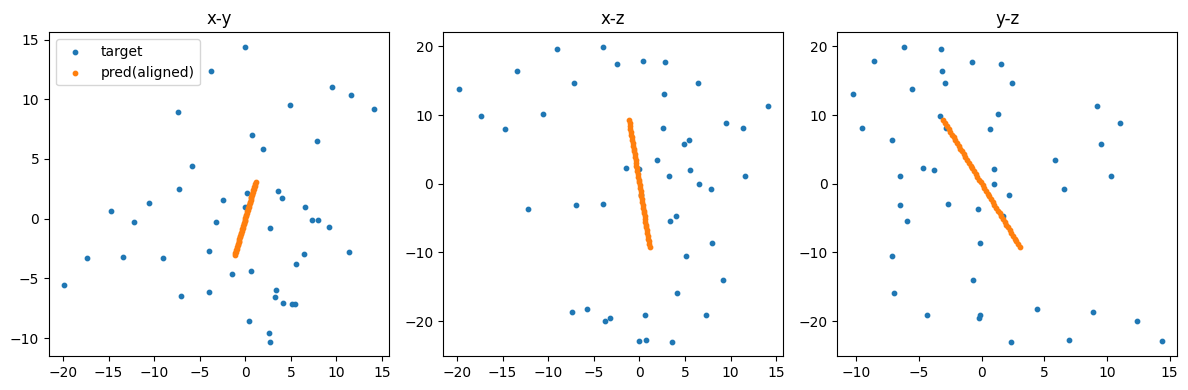

In [10]:
# ==========================================
# 10) Quick sanity check on holdout batch  [v10]
#   - pick best head by TM-score (competition aligned) for sample 0
# ==========================================
import matplotlib.pyplot as plt

model.eval()
tokens_b, tgt_b, m_b = next(iter(hold_loader))
tokens_b = tokens_b.to(device)
tgt_b = tgt_b.to(device)
m_b = m_b.to(device)

with torch.no_grad():
    coords_b, conf_b, _ = model(tokens_b)  # coords (B,K,T,3), conf (B,K), distmat (B,T,T)

# choose sample 0
preds0 = coords_b[0]   # (K,T,3)
tgt0 = tgt_b[0]        # (T,3)
mask0 = m_b[0]         # (T,)

# compute TM-score per head (after Kabsch), pick best
tms = []
aligned = []
for k in range(preds0.size(0)):
    pk = preds0[k:k+1]  # (1,T,3)
    tk = tgt0.unsqueeze(0)
    mk = mask0.unsqueeze(0)
    pk_al = kabsch_align(pk, tk, mk)[0].detach().cpu()
    aligned.append(pk_al)

    # TM-score for this sample/head
    tm = tm_score_single(pk, tk, mk)[0].item()
    tms.append(tm)

best_k = int(np.argmax(tms))
pred_best = aligned[best_k].numpy()
tgt_np = tgt0.detach().cpu().numpy()
mask_np = mask0.detach().cpu().numpy()

print("TM per k:", [round(x,4) for x in tms], "best_k:", best_k)
if conf_b is not None:
    print("conf logits:", conf_b[0].detach().cpu().numpy().round(3))

valid = mask_np.astype(bool)
x_t, y_t, z_t = tgt_np[valid].T
x_p, y_p, z_p = pred_best[valid].T

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].scatter(x_t, y_t, s=10, label='target')
axes[0].scatter(x_p, y_p, s=10, label='pred(aligned)')
axes[0].set_title('x-y'); axes[0].legend()

axes[1].scatter(x_t, z_t, s=10)
axes[1].scatter(x_p, z_p, s=10)
axes[1].set_title('x-z')

axes[2].scatter(y_t, z_t, s=10)
axes[2].scatter(y_p, z_p, s=10)
axes[2].set_title('y-z')
plt.tight_layout()
plt.show()


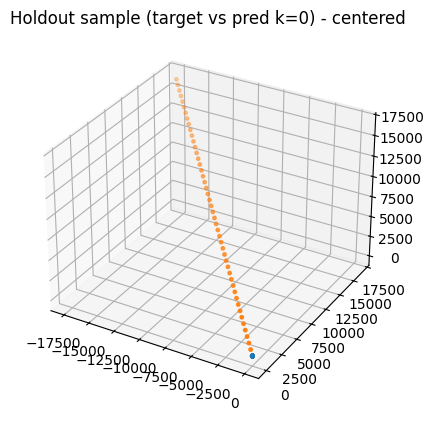

In [11]:
# ==========================================
# 10) Quick visualization on holdout batch (k=0)
# ==========================================
import matplotlib.pyplot as plt

model.eval()
tokens_b, tgt_b, m_b = next(iter(hold_loader))
tokens_b = tokens_b.to(device)
tgt_b = tgt_b.to(device)
m_b = m_b.to(device)

with torch.no_grad():
    # 모델이 (coords, conf_logits) 튜플을 반환하므로 좌표만 받습니다.
    coords_b, _, _ = model(tokens_b)
pred0 = coords_b[0,0].detach().cpu().numpy()
tgt0  = tgt_b[0].detach().cpu().numpy()
m0    = m_b[0].detach().cpu().numpy().astype(bool)

pred0 = pred0[m0]
tgt0  = tgt0[m0]

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(tgt0[:,0], tgt0[:,1], tgt0[:,2], s=6)
ax.scatter(pred0[:,0], pred0[:,1], pred0[:,2], s=6)
ax.set_title("Holdout sample (target vs pred k=0) - centered")
plt.show()